all data has been collected from official tournaments websites on https://www.fiba.basketball/
FIBA collects game stats on server via on-premise staticians using the FIBA LiveStats Software
Data for international events for each game is saved in minimum 7 seperate Json files: Game, CompetitionDetail, Play-By-Play Files each quarter seperately (for a non overtime game, 4 Files)

for project convenience files has been collected before, and aggregated in excel files for simplifications, but one sample from each Json file has been put in Data folder for demonstration purposes.

Excel Files has been put in Data folder categorized by tournaments
Games File contain teams game by game stats
Logos Folder contain flag of each country, labeled by abbreviated names for illustration purposes

Importing appropriate libraries and Files
Before Running this code, choose the appropriate tournament by setting i according the list index

In [103]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Loading Raw Play-By-Play File
dt = pd.read_excel(".\Data\Sample pbp file.xlsx")

# using list index for convenience 
tours = ['2019  FIBA, Asian Qualifiers', '2019  FIBA, World Cup', '2022  FIBA, Asia Cup', '2023  FIBA, Asian Qualifiers']


# Set i from 0 to 3, to choose the approrpiate tournament
i = 3


# takes time as String, returns time as float number
def timeToNumber(time):
    m, s = [int(x) for x in time.split(':')]
    return m + round(s/60,2)


# Reads Json file .txt from Data Folder
def jsonopener(file):
    with open(f".\Data\\{file}", 'r') as json_file:
        data = json.load(json_file)
    return data



First Step is Cleaning the Play-By-Play Files
FIBA uses abbreviations, different styles of game tracking, we transform and simplify data for calculation purposes
Sample Game File has been put in the project directory, Results will be exported to the same directory labeled "Results.xlsx"

In [104]:
# Refines original Play-By-Play File
def pbp(df):

    # Loading Game File
    game = jsonopener(f'sample Game.txt')
    team = game['content']['full']['Competitors']

    # Loading the Number of Periods in the Game
    try:
        game = game['content']['full']['Periods']
    except KeyError:
        # Catches the error for file past 2022
        game = game['content']['full']['ScoreList']

    # Loading the Competition Details
    data = jsonopener(f'sample Compdetails.txt')
    compdetail = data['content']['full']['Competitors']

    # Dropping Useless Columns
    df.drop('GT', inplace=True, axis=1)
    df.drop('Score', inplace=True, axis=1)

    # Reseting index to start from 0
    df.reset_index(inplace=True)

    # Inserting a New Column "Time Chron", to show chronological time, placed at 7th position
    df.insert(7, 'Time Chron', 0)

    # Converting Countdown Scoreboard time to game real time starting from 0:00 to 10:00
    for ct, timet in enumerate(df['Time']):
        c = timet.find(':')
        a = timet[:c]
        b = timet[c + 1:]
        if timet == '10:00':
            df.loc[ct, "Time"] = '0:00'
        else:
            if timet == '00:00':
                df.loc[ct, "Time"] = '10:00'
            elif 60 - int(b) == 60:
                df.loc[ct, "Time"] = f'{9 - int(a) + 1}:0{0}'
            elif len(str(60 - int(b))) < 2:
                df.loc[ct, "Time"] = f'{9 - int(a)}:0{60 - int(b)}'
            else:
                df.loc[ct, "Time"] = f'{9 - int(a)}:{60 - int(b)}'

    # Convering time from String MM:SS to float by Minutes
    for x, tm in enumerate(df['Time']):
        df.loc[x, 'Time Chron'] = timeToNumber(tm)

    # Cleaning Time, to covert to chronological, 0 - 40 Minutes in a new column Time Chron
    dt = list(df.loc[df['AC'].isin(['ENDP'])].index.values)
    z = 0
    for y, indval in enumerate(df['Time Chron']):
        if dt[0] < y:
            if len(dt) > 1:
                dt.pop(0)
                z += 1
        tmp = indval + 10 * z
        df.loc[y, 'Time Chron'] = round(tmp, 2)

    # Cleans T1, Team Names Replacing ID with Actual Team Names
    for i in [0, 1]:
        team_code = team[i]['TeamCode']
        teamid = team[i]['Id']
        df.loc[df['T1'] == teamid, 'T1'] = team_code
        compdetail.pop(team[i]['Id'])

    # Cleans C1, Replacing ID with Actual Player Names
    for id in compdetail:
        pfname = compdetail[id]['FirstName']
        plname = compdetail[id]['Name']
        df.loc[df['C1'] == id, 'C1'] = f'{pfname} {plname}'

    # Cleans Abbreviations in the Data
    # Dictionary providing Abbreviated Words
    dic = {'P3': '3P', 'P2': '2P',
           'LU': 'Layup', 'DU': 'Dunk', 'AO': 'Alley-Oop', 'DL': 'Driving Layup', 'HS': 'Hook Shot',
           'TJ': 'Turnaround Jumpshot', 'PJ': 'Pull-up Jumpshot', 'SJ': 'Step-Back Jumpshot',
           'FL': 'Floating Jumpshot', 'FA': 'Fadeaway Jumpshot',
           'D': 'Defensive', 'O': 'Offensive',
           'SC': 'Second Chance', 'FB': 'Fastbreak',
           'TO': 'Turnover', 'OB': 'Out of Bounds', 'BP': 'Bad Pass', 'DD': 'Double Dribble', 'TR': 'Travel',
           'LB': 'Ball Handling', 'VI': 'Back Court',
           'P': 'Personal Foul', 'SF': 'Shooting Foul', 'U': 'Unsportmanlike', 'T': 'Technical',
           'TC': 'Coach Technical', 'ST': 'Steal'}

    # Replaces JS as jumpshot with 2P or 3P to specify shot value
    for x, it in enumerate(df['Z3']):
        if it == 'JS':
            df.loc[x, "Z3"] = df.loc[x, 'AC']

    # Replaces Abbriviations in Z1, Z2, Z3 as provided in dictionary above
    for k in dic:
        df.loc[df['Z3'] == k, 'Z3'] = dic[k]
        df.loc[df['Z2'] == k, 'Z2'] = dic[k]
        df.loc[df['Z1'] == k, 'Z1'] = dic[k]


    # Replacing 'AL' with Second Chance
    df.loc[df['Z2'] == 'AL', 'Z2'] = 'Second Chance'


    # Replacing +/- values in SU column with 1/0,
    df.loc[df['SU'] == '+', 'SU'] = 1
    df.loc[df['SU'] == '-', 'SU'] = 0

    # Removing index column
    df.drop('index', inplace=True, axis=1)

    # Reseting index to replace the previous dropped one
    df.reset_index(inplace=True)

    # Adding Q column to indicate Quarter
    df['Q'] = 0
    x = 0
    p = 1
    tmp = df.loc[df['Action'].isin(['End of Period'])].index
    for ind in tmp:
        for i in range(x, ind + 1):
            df.loc[i, 'Q'] = p
        p += 1
        x = ind + 1
    df.loc[df.iloc[-1]['index'], 'Q'] = p - 1

    # Fixing RFOUL Z2 column, adding number of FT awarded to the foul receiver
    sfouls = df.loc[df['AC'].isin(['FOUL']) & ~df['Z2'].isin([''])]
    for ind, z2 in zip(sfouls['index'], sfouls['Z2']):
        df.loc[ind + 1, 'Z2'] = z2

    ## Replacing 0 values instead of B in older file format past 2022
    df.loc[df.loc[df['SU'].isin(['B'])].index, 'SU'] = 0

    ## Adding PId (Previous Id) for each necessary actions in files past 2022
    if 'PId' not in df.columns:
        df['PId'] = None

        # Fixing Offensive Fouls PId
        offtodf = df.loc[df['AC'].isin(['FOUL']) & df['Z1'].isin(['Offensive'])]
        df.loc[offtodf.index + 1, 'Z1'] = df.loc[offtodf.index, 'Z1'].values
        for ind in offtodf.index:
            df.loc[ind + 1, 'PId'] = df.loc[ind, 'Id']

        # Fixing Turnovers and Steals
        temp_df = df.loc[df['AC'].isin(['TO', 'ST'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'ST']['Id'].index
                df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'TO']['Id'].values[0]

        # Fixing Fouls and Received Fouls PId
        temp_df = df.loc[df['AC'].isin(['RFOUL', 'FOUL'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'RFOUL']['Id'].index
                df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'FOUL']['Id'].values[0]

        # Fixing Assisted Shots PId
        temp_df = df.loc[df['AC'].isin(['P2', 'P3', 'ASS'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'ASS']['Id'].index
                if tdf['AC'].values[0] == 'P2':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P2']['Id'].values[0]
                elif tdf['AC'].values[0] == 'P3':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P3']['Id'].values[0]

        # Fixing Blocked Shots PId
        temp_df = df.loc[df['AC'].isin(['BS', 'P2', 'P3'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'BS']['Id'].index
                if tdf['AC'].values[0] == 'P2':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P2']['Id'].values[0]
                elif tdf['AC'].values[0] == 'P3':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P3']['Id'].values[0]

        # Fixing JB (Jumpball) in Actions column (AC)
        df.loc[df[df['AC'] == 'JB'].index.values, 'PId'] = df.loc[df['AC'].isin(['JS'])]['Id'].values[0]


        # Fixing Rebounds and Team Rebounds PId
        temp_df = df.loc[(df['AC'].isin(['P2', 'P3']) & df['SU'].isin([0])) | (df['AC'].isin(['FT']) & (df['Z1'] == df['Z2']) & df['SU'].isin([0]))]
        testdf = pd.DataFrame(columns=['index', 'AC', 'Action', 'Id', 'Time', 'Z1', 'Z2', 'Time Chron', 'Z3', 'C1', 'SA', 'SB', 'T1','SU', 'SX', 'SY', 'R', 'Q', 'PId'])
        for ind in temp_df['index']:
            testdf.loc[ind] = temp_df.loc[ind]

            if (df.loc[ind + 1]['AC'] == 'REB') or (df.loc[ind + 1]['AC'] == 'TREB'):
                df.loc[ind + 1, 'PId'] = temp_df.loc[ind, 'Id']

            elif (df.loc[ind + 2]['AC'] == 'REB') or (df.loc[ind + 2]['AC'] == 'TREB'):
                df.loc[ind + 2, 'PId'] = temp_df.loc[ind, 'Id']

            try:
                if (df.loc[ind + 3]['AC'] == 'REB') or (df.loc[ind + 3]['AC'] == 'TREB'):
                    df.loc[ind + 3, 'PId'] = temp_df.loc[ind, 'Id']
            except KeyError:
                continue

    # Adding Offensive Attribute in Z1 for the consecutive action
    offtodf = df.loc[df['AC'].isin(['FOUL']) & df['Z1'].isin(['Offensive'])]
    df.loc[offtodf.index + 1, 'Z1'] = df.loc[offtodf.index, 'Z1'].values

    # Exporting the Results in an Excel File in Project Directory
    print(df)

pbp(dt)

     index      AC           Action   Id  SA  SB   Time  Time Chron  \
0        0  STARTG    Start of Game    1   0   0   0:00        0.00   
1        1  STARTP  Start of Period    2   0   0   0:00        0.00   
2        2      JS              NaN    4   0   0   0:00        0.00   
3        3      JB              NaN    5   0   0   0:01        0.02   
4        4      JB              NaN    6   0   0   0:01        0.02   
..     ...     ...              ...  ...  ..  ..    ...         ...   
536    536    FOUL              NaN  713  76  69   9:58       39.97   
537    537   RFOUL              NaN  714  76  69   9:58       39.97   
538    538      P3              NaN  718  76  69  10:00       40.00   
539    539    ENDP    End of Period  720  76  69  10:00       40.00   
540    540    ENDG      End of Game  721  76  69  10:00       40.00   

                Z1   Z2   Z3                 C1   T1    PId   SU     SX  \
0              NaN  NaN  NaN                NaN  NaN    NaN  NaN    NaN 

Next we're calculating Average Statistics for teams and players from game by game files

In [111]:
# Reads Games File, Returns Teams Average Stats Excel file
def teamMean():
    cols = ['Team', 'Id', 'W%', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', '2PM', '2PA', '2P%',
            'FTM', 'FTA', 'FT%', 'DR', 'OR', 'TR', 'AST', 'TO', 'STL', 'BLK', 'PF', 'PFD', 'Bench', 'MidRangePTS',
            'MidRangeM', 'MidRangeA', 'MidRange%', 'PaintPTS', 'PaintM', 'PaintA', 'Paint%', 'W/L']
    data = pd.DataFrame(columns=cols[:-1])

    file = pd.read_excel(f".\Data\\{tours[i]}\Games.xlsx")
    teams = file.drop_duplicates('Team')['Team']

    for ind, tm in enumerate(teams):
        accu = file[file['Team'] == tm]
        temp = accu[cols[3:-1]]
        data.loc[ind] = round(temp.mean(), 2)

        data.loc[ind, 'Team'] = tm
        data.loc[ind, 'Id'] = accu['Id'].values[0]
        gp = accu['Id'].count()
        data.loc[ind, 'GP'] = gp
        w = len(accu['W/L'].loc[accu['W/L'].isin(['W'])])
        data.loc[ind, 'W'] = w
        data.loc[ind, 'L'] = len(accu['W/L'].loc[accu['W/L'].isin(['L'])])
        data.loc[ind, 'W%'] = round(w / gp * 100, 2)
    print(data)

teamMean()

   Team     Id      W%    PTS    FGM    FGA    FG%    3PM    3PA    3P%  ...  \
0   AUS   T_16  100.00  85.50  32.50  67.17  48.42  11.33  29.33  38.03  ...   
1   CHN   T_39   66.67  82.17  30.33  62.67  48.60   8.17  23.00  35.53  ...   
2   JPN   T_85   33.33  69.50  23.33  63.67  36.67   9.67  36.17  26.68  ...   
3   TPE  T_146    0.00  61.00  23.50  67.50  34.73   6.33  22.33  28.45  ...   
4   BRN   T_19   33.33  63.33  23.67  63.33  37.46   8.17  26.50  29.96  ...   
5   IRI  T_879   66.67  80.33  30.33  67.50  45.03   5.50  19.50  28.18  ...   
6   KAZ  T_739   83.33  75.33  26.50  65.17  40.30   9.67  30.17  31.50  ...   
7   SYR  T_145   16.67  69.33  24.17  62.50  38.74   5.33  21.00  25.33  ...   
8   INA   T_78    0.00  58.50  20.83  65.00  32.51   7.83  32.33  24.88  ...   
9   JOR   T_86   66.67  74.50  26.17  61.67  42.13   8.00  24.67  32.53  ...   
10  KSA  T_132   50.00  70.83  25.50  65.17  38.82   6.83  25.33  27.13  ...   
11  LBN   T_93   83.33  88.17  30.67  65

Next we draw histograms, load the code below for required fuctions for Histograms Data
Here we'll calculate extra data we need based on the basic data we have,
we have number of attempts made from each scoring category, we'll calculate the percentage of total attempts and points for every category

In [112]:
# Gets image Path and Changes Image Zoom depending on the Tournament
def getImage(path, i):
    if i == 0:
        ## 2019 - FIBA, Asian Qualifiers, China
        return OffsetImage(plt.imread(path), zoom = 0.006)
    elif i == 1:
        ## 2019 - FIBA, World Cup, China
        return OffsetImage(plt.imread(path), zoom = 0.08)
    else:
        ## 2022 - FIBA, Asia Cup, Indonesia
        ## 2023 - FIBA, World Cup, Asian Qualifiers
        return OffsetImage(plt.imread(path), zoom = 0.2)
    

# Receives DataFrame with Teams Average, Returns Attempt percentage Related Columns data frame along with colmns and factors list
def pointsCalculator(data):
    dt = pd.DataFrame(data[['Team', 'PTS', 'MidRangePTS', 'PaintPTS', '3PM', 'FTM']])

    dt['MidRangePTS'] = round(dt['MidRangePTS'] / dt['PTS'] * 100)
    dt['PaintPTS'] = round(dt['PaintPTS'] / dt['PTS'] * 100)
    dt['3PTS'] = dt['3PM'] * 3
    dt['3PTS'] = round(dt['3PTS'] / dt['PTS'] * 100)
    dt['FT PTS'] = round(dt['FTM'] / dt['PTS'] * 100)

    dt = dt[['Team', 'PTS', 'MidRangePTS', 'PaintPTS', '3PTS', 'FT PTS']]

    cols = ['MidRange Share', 'Paint Share', '3P Share', 'FT Share']
    factors = ['MidRangePTS', 'PaintPTS', '3PTS', 'FT PTS']

    return dt, cols, factors


# Receives DataFrame with Teams Average, Returns points Related Columns data frame along with colmns and factors list
def attemptsCalculator(data):
    dt = pd.DataFrame(data[['Team', 'MidRangeA', 'PaintA', '3PA', 'FTA', 'FGA']])

    dt['FGA'] = dt['FGA'] + dt['FTA']

    dt['MidRangeA'] = round(dt['MidRangeA'] / dt['FGA'] * 100)
    dt['PaintA'] = round(dt['PaintA'] / dt['FGA'] * 100)
    dt['3PA'] = round(dt['3PA'] / dt['FGA'] * 100)
    dt['FTA'] = round(dt['FTA'] / dt['FGA'] * 100)

    cols = ['MidRange Attempts', 'Paint Attempts', '3P Attempts', 'FT Attempts']
    factors = ['MidRangeA', 'PaintA', '3PA', 'FTA']
    
    dt = dt[['Team', 'MidRangeA', 'PaintA', '3PA', 'FTA']]
    return dt, cols, factors

Using the above created data, we'll plot the histograms individually to add country flags as labels on the chart

<Figure size 432x288 with 0 Axes>

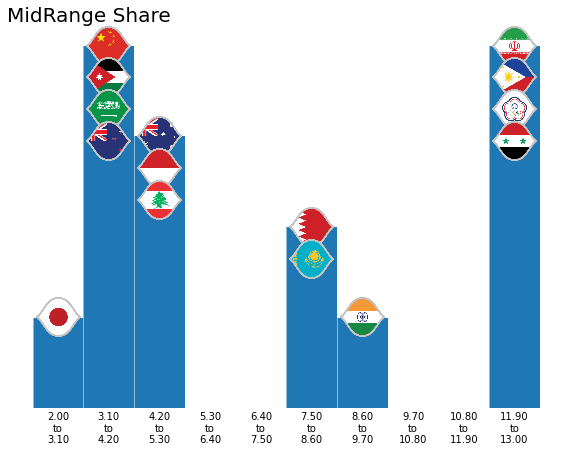

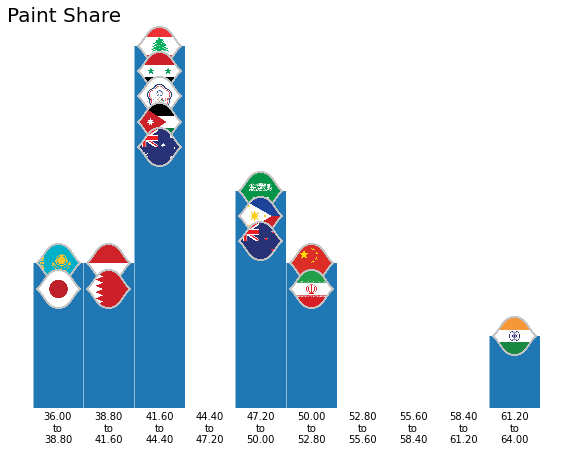

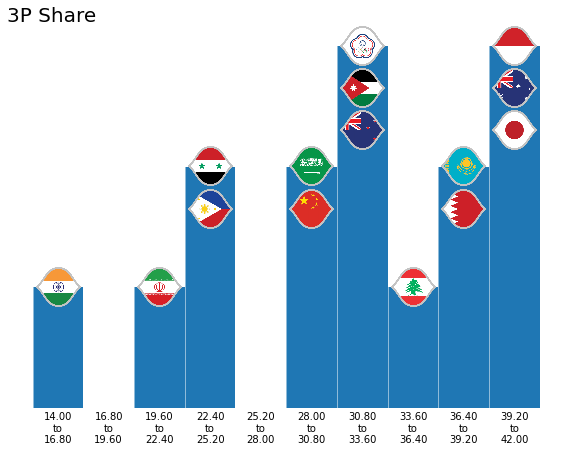

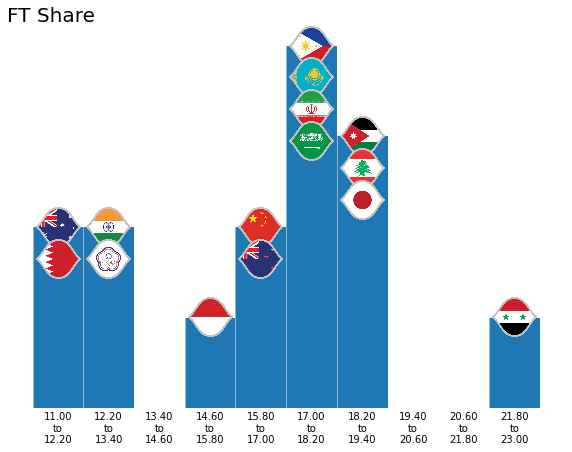

In [113]:
# Uses Attempts and Points Calculators Data to Plot Histograms for each indicator individually and shows it at the end
# First Define Action to show Points/Attempts histogram
# Adds the flag of every country to the appropriate label
def histogramPlotter():
    action = 'Points'
    
    data = pd.read_excel(f".\Data\\{tours[i]}\Teams Average.xlsx")

    if action == 'Points':
        data, cols, factors = pointsCalculator(data)
    elif action == 'Attempts':
        data, cols, factors = attemptsCalculator(data)

    plt.clf()
    for factor, col in zip(factors, cols):

        fig, ax = plt.subplots(1, figsize=(10, 7))

        data.sort_values(factor, inplace=True)
        n, bins, patches = plt.hist(data[factor])

        # grid
        minor_locator = AutoMinorLocator(2)
        plt.gca().xaxis.set_minor_locator(minor_locator)
        plt.grid(which='minor', color='white', lw=0.5)  # x ticks
        xticks = [(bins[idx + 1] + value) / 2 for idx, value in enumerate(bins[:-1])]
        xticks_labels = ["{:.2f}\nto\n{:.2f}".format(value, bins[idx + 1]) for idx, value in enumerate(bins[:-1])]
        plt.xticks(xticks, labels=xticks_labels)

        # remove major and minor ticks from the x axis, but keep the labels
        ax.tick_params(axis='x', which='both', length=0)

        # remove y ticks
        plt.yticks([])  # Hide the right and top spines
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        prev = 0
        for (idx, value), bn in zip(enumerate(n), bins[1:]):
            tms = data.loc[(data[factor] >= prev) & (data[factor] < bn)]['Team'].values

            pad = 0
            for tm in tms:
                path = f'.\Data\Logos\\{tours[i]}\\{tm}.png'
                ab = AnnotationBbox(getImage(path, i), (xticks[idx], value - pad), frameon=False)
                ax.add_artist(ab)
                pad += 0.35
            prev = bn

        tms = data.loc[(data[factor] >= prev) & (data[factor] <= bn)]['Team'].values

        for tm in tms:
            path = f'.\Data\Logos\\{tours[i]}\\{tm}.png'
            ab = AnnotationBbox(getImage(path, i), (xticks[idx], value - pad), frameon=False)
            ax.add_artist(ab)
            pad += 0.35

        plt.title(f'{col}', loc='left', fontsize=20)
        plt.show()
        
histogramPlotter()

At The end we plot one last line plot

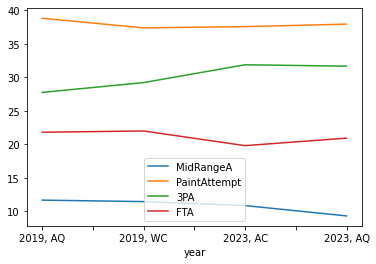

In [114]:
# Plotting Total Attempts in different Tournaments with Line Chart
def linePlotter():
    data = pd.read_excel(f".\Data\Total Attempts.xlsx")
    data = data.groupby('year').mean()
    data.plot()
    plt.show()
linePlotter()